# 2D plotting of LES output vs. synthetic aperture radar (work in progress)
* The below notebook compares selected simulations against observational targets that were collected from satellite.
* In case of questions or concerns, please notify Ann Fridlind (ann.fridlind@nasa.gov), Timothy Juliano (tjuliano@ucar.edu), and Florian Tornow (ft2544@columbia.edu).

In [14]:

import glob, os
import geopy
import geopy.distance

os.getcwd()


'/user-data-home/comble-mip/notebooks/plotting'

In [117]:
os.chdir("/user-data-home/comble-mip/notebooks/plotting/")

%run functions_plotting.py 

## read trajectory
ds = nc.Dataset('../../data_files/theta_temp_rh_sh_uvw_sst_along_trajectory_era5ml_28h_end_2020-03-13-18.nc')
les_time = 18. + ds['Time'][:]
    
## select simulations to plot
sim_keyword = 'FixN_2D'  

In [110]:
## select times
Time_Vec = [2.] ## hours, where 18 h marks arrival

## select acceptable window of time
Time_Window = 15.0  ## hours

## set domain to be extracted
Spat_Window = 100.0 ## km


In [111]:
## convert to regular time
tprop = []
for toi in Time_Vec:
    tprop.append(np.datetime64('2020-03-13T00:00:00') + np.timedelta64(int(toi),'h'))
print (tprop)           

[numpy.datetime64('2020-03-13T02:00:00')]


In [112]:
## load sar imagery

sar_dir = "/data/project/comble-mip/sar_imagery/"
os.chdir(sar_dir)
counter_dat = 0
for file in glob.glob("*wind_level2.nc"):
    
    ## load file
    ds_sar = xr.open_dataset(sar_dir + file)
    
    ## time
    file_time = ds_sar['acquisition_time'].data
    
    ## for each requested model timestep, check if image covers right place at right time
    counter_time = 0
    for Time_OI in tprop:
        diff_time = (file_time - np.datetime64(Time_OI))/np.timedelta64(1, 's')/3600
        if np.abs(diff_time) <= Time_Window:
            print(Time_OI)
            Traj_time = (Time_OI - np.datetime64('2020-03-13T18:00:00'))/np.timedelta64(1, 's')/3600
            Lat_OI = ds['Latitude'][ds['Time'][:]==Traj_time][0]
            Lon_OI = ds['Longitude'][ds['Time'][:]==Traj_time][0]
            
            ## create spatial window around coordinate of interest
            start = geopy.Point(Lat_OI, Lon_OI)
            d = geopy.distance.distance(kilometers=1.2*Spat_Window/2)
            
            LAT_MIN = d.destination(point=start, bearing=180)[0]
            LAT_MAX = d.destination(point=start, bearing=0)[0]
            LON_MIN = d.destination(point=start, bearing=270)[1]
            LON_MAX = d.destination(point=start, bearing=90)[1]
            
            #print(LAT_MIN,LAT_MAX,LON_MIN,LON_MAX)
            
            SliceData = ds_sar.where((ds_sar['latitude'][:,:] > LAT_MIN) & 
                                     (ds_sar['latitude'][:,:] < LAT_MAX) & 
                                     (ds_sar['longitude'][:,:] > LON_MIN)& 
                                     (ds_sar['longitude'][:,:] < LON_MAX),drop=True)
            #print (SliceData['latitude'])
            
            ## select pixels within window
            pix_num = ((ds_sar['latitude'][:,:] > LAT_MIN) & 
                       (ds_sar['latitude'][:,:] < LAT_MAX) & 
                       (ds_sar['longitude'][:,:] > LON_MIN)& 
                       (ds_sar['longitude'][:,:] < LON_MAX)).sum()
            #print(pix_num)
            
            if pix_num > 0:
                
                ds_wind = SliceData['sar_wind'][:,:]
                ds_lat = SliceData['latitude'][:,:]
                ds_lon = SliceData['longitude'][:,:]
                
                da = xr.DataArray(
                    name = 'wind_10m',
                    data = ds_wind,
                    dims = ['y','x'],
                    coords = dict(
                        lon = (['y','x'],ds_lon.data),
                        lat = (['y','x'],ds_lat.data)
                    ))
            
                ## compute meridional and latitudal distance to center
                da['x_dist'] = 0*da['lat']
                da['y_dist'] = 0*da['lat']
                print (ds_wind.shape)
                for jj in tqdm(range(ds_wind.shape[0])):
                    for ii in range(ds_wind.shape[1]):
                        da['x_dist'][jj,ii] = geopy.distance.geodesic((da['lat'][jj,ii],da['lon'][jj,ii]), 
                                                                      (da['lat'][jj,ii],Lon_OI)).km * np.sign((da['lon'][jj,ii].data - Lon_OI))
                        da['y_dist'][jj,ii] = geopy.distance.geodesic((da['lat'][jj,ii],da['lon'][jj,ii]), 
                                                                      (Lat_OI,da['lon'][jj,ii])).km * np.sign((da['lat'][jj,ii].data - Lat_OI)) 
                
                ## limit to requested size
                da = da.where((da['y_dist'][:,:] <= Spat_Window/2) & (da['x_dist'][:,:] <= Spat_Window/2),drop=True)
                
                ## normalize radiance values to resemble LES pseudo-albedo
                #da.data = ((da.data - da.data.min())/(da.data.max() - da.data.min()))*0.8
                    
                #da['x_round'] = np.round(da['x_dist'])
                #da['y_round'] = np.round(da['y_dist'])
                
                #for yy in np.unique(da['y_round']):
                #    da_sub = da[da['y_round'] == yy]
                #    da_stat = da_sub.groupby('x_round').mean() 
                #    da_stat['y_round'] = np.float64(yy)
                #    if yy == np.unique(da['y_round'])[0]:
                #        da_stat_stack = xr.concat([da_stat],dim='y_round')
                #    else:
                #        da_stat_stack = xr.concat([da_stat_stack,da_stat],dim='y_round')
                
                da_stat_stack = da
                da_stat_stack['time'] = Time_OI
                da_stat_stack['time_diff'] = diff_time
                if counter_time == 0:
                    da_stat_stst = xr.concat([da_stat_stack],dim='time')
                else:
                    da_stat_stst = xr.concat([da_stat_stst,da_stat_stack],dim='time')
                counter_time += 1
                
    da_stat_stst['Source'] = file
    if counter_dat == 0:
        da_stat_ststst = xr.concat([da_stat_stst],dim='Source')
    else:
        da_stat_ststst = xr.concat([da_stat_ststst,da_stat_stst],dim='Source')
    counter_dat += 1

2020-03-13T02:00:00
(308, 310)


100%|██████████| 308/308 [02:39<00:00,  1.93it/s]


In [105]:
############################### TIM TEST, IGNORE FOR NOW
## limit to requested size
da = da.where((da['y_dist'][:,:] <= Spat_Window/2) & (da['x_dist'][:,:] <= Spat_Window/2),drop=True)

da['x_round'] = np.round(da['x_dist'])
da['y_round'] = np.round(da['y_dist'])

for yy in tqdm(np.unique(da['y_round'])):
    for xx in np.unique(da['x_round']):
        da_sub = da.where((da['y_round'] == yy) & (da['x_round'] == xx),drop=True)
        da_stat = da_sub.mean()
        da_stat['y_round'] = np.float64(yy)
        da_stat['x_round'] = np.float64(xx)
        print (da_stat)
        if (yy == np.unique(da['y_round'])[0] and xx == np.unique(da['x_round'])[0]):
            da_stat_stack = xr.concat([da_stat],dim)
        else:
            da_stat_stack = xr.concat([da_stat_stack,da_stat])

da_stat_stack['time'] = Time_OI
da_stat_stack['time_diff'] = diff_time
if counter_time == 0:
    da_stat_stst = xr.concat([da_stat_stack],dim='time')
else:
    da_stat_stst = xr.concat([da_stat_stst,da_stat_stack],dim='time')
counter_time += 1

da_stat_stst['Source'] = file
if counter_dat == 0:
    da_stat_ststst = xr.concat([da_stat_stst],dim='Source')
else:
    da_stat_ststst = xr.concat([da_stat_ststst,da_stat_stst],dim='Source')
counter_dat += 1

  0%|          | 0/190 [00:00<?, ?it/s]

<xarray.DataArray 'wind_10m' ()> Size: 4B
array(nan, dtype=float32)
Coordinates:
    y_round  float64 8B -102.0
    x_round  float64 8B -99.0


TypeError: concat() missing 1 required positional argument: 'dim'

In [113]:
da_stat_ststst

<xarray.DataArray 'wind_10m' (Source: 1, time: 1, y: 283, x: 310)> Size: 351kB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
    lon        (y, x) float32 351kB 9.965 9.945 9.925 9.905 ... 1.5 1.479 1.459
    lat        (y, x) float32 351kB 78.41 78.41 78.42 ... 77.73 77.73 77.73
    x_dist     (y, x) float32 351kB 97.47 97.0 96.54 ... -97.74 -98.21 -98.68
    y_dist     (y, x) float32 351kB 28.2 28.41 28.63 ... -47.82 -47.66 -47.51
  * time       (time) datetime64[ns] 8B 2020-03-13T02:00:00
    time_diff  float64 8B 4.939
  * Source     (Source) <U83 332B 'S1B_ESA_2020_03_13_06_56_19_0637397779_006...
Dimensions without coordinates: y, x
Attributes:
    units:                  m s-1
    long_name:              SAR-derived wind speed at 10-m height neutral sta...
    standard_name:          wind_speed
    coverage_content_type:  physicalMeasurement
    valid_min:              0.0
    valid_max:              100.0
    grid_mappig:            NONE
    source:                 SAR imagery European Space Agency (ESA)
    reference:              NONE
    platform:               SENTINEL-1B
    instrument:             SAR
    Comment:                NONE

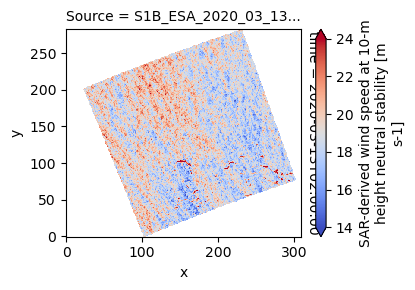

In [121]:
da_stat_ststst.plot(row='time',col='Source',vmin=14,vmax=24,cmap='coolwarm')

In [122]:
os.chdir("/user-data-home/comble-mip/notebooks/plotting/")
%run functions_plotting.py 

var_vec_2d = ['us','vs']

## load all simulations located in subfolders of the given directory
df_col_2d = load_sims_2d('/data/project/comble-mip/output_les/',var_vec_2d,t_shift=-2,keyword=sim_keyword,times=[t for t in Time_Vec if t > 0],coarsen=True)

Loading variables: f(time,x,y)
/data/project/comble-mip/output_les/wrf/WRF_Lx25_dx100_FixN_2D.nc
/data/project/comble-mip/output_les/dharma/DHARMA_Lx25_dx100_FixN_2D.nc
/data/project/comble-mip/output_les/uclales-salsa/UCLALES-SALSA_Lx25_dx100_FixN_2D.nc
...adjusting x and y values


In [ ]:
#df_col_2d['alb'].plot(row='time',col_wrap=7,col='Source')

In [123]:
df_col_2d['wspd'] = np.sqrt(pow(df_col_2d['us'],2.) + pow(df_col_2d['us'],2.))

In [125]:
df_col_2d

<xarray.Dataset> Size: 211kB
Dimensions:  (y_round: 27, x_round: 27, Source: 3, time: 1)
Coordinates:
  * x_round  (x_round) float64 216B -13.0 -12.0 -11.0 -10.0 ... 11.0 12.0 13.0
  * time     (time) datetime64[ns] 8B 2020-03-13T02:00:00
  * Source   (Source) <U49 588B 'wrf/WRF_Lx25_dx100_FixN_2D.nc' ... 'uclales-...
  * y_round  (y_round) float64 216B -13.0 -12.0 -11.0 -10.0 ... 11.0 12.0 13.0
Data variables:
    hfss     (y_round, x_round, Source, time) float64 17kB 694.6 726.6 ... 786.9
    hfls     (y_round, x_round, Source, time) float64 17kB 305.9 323.7 ... 377.4
    ustar    (y_round, x_round, Source, time) float64 17kB 0.8404 nan ... 0.8391
    us       (y_round, x_round, Source, time) float64 17kB 5.184 5.049 ... 2.636
    vs       (y_round, x_round, Source, time) float64 17kB -17.16 ... -18.27
    pr       (y_round, x_round, Source, time) float64 17kB nan 0.0 ... 1.146e-05
    lwp      (y_round, x_round, Source, time) float64 17kB nan ... 1.816e-08
    iwp      (y_round, x_round, Source, time) float64 17kB nan ... 0.03078
    opt      (y_round, x_round, Source, time) float64 17kB nan 3.05 ... 0.456
    alb      (y_round, x_round, Source, time) float64 17kB nan ... 0.03387
    olr11    (y_round, x_round, Source, time) float64 17kB nan 250.5 ... 304.2
    wspd     (y_round, x_round, Source, time) float64 17kB 7.332 7.14 ... 3.728
Attributes: (12/17)
    title:           WRF LES results for COMBLE-MIP case: fixed Nd and Ni
    reference:       https://github.com/ARM-Development/comble-mip
    authors:         Tim Juliano (tjuliano@ucar.edu)
    version:         2024-08-07 11:59:53
    format_version:  DEPHY SCM format version 1.6
    script:          convert_WRF_LES_output_to_dephy_format.ipynb
    ...              ...
    dx:              100.0 m
    dy:              100.0 m
    dz:              see ze variable
    nx:              256
    ny:              256
    nz:              159

/tmp/ipykernel_314/1466553009.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  xr.merge([df_col_2d['wspd'],da_stat_ststst.drop('time_diff')])['wind_10m'].plot(row='time',col='Source')


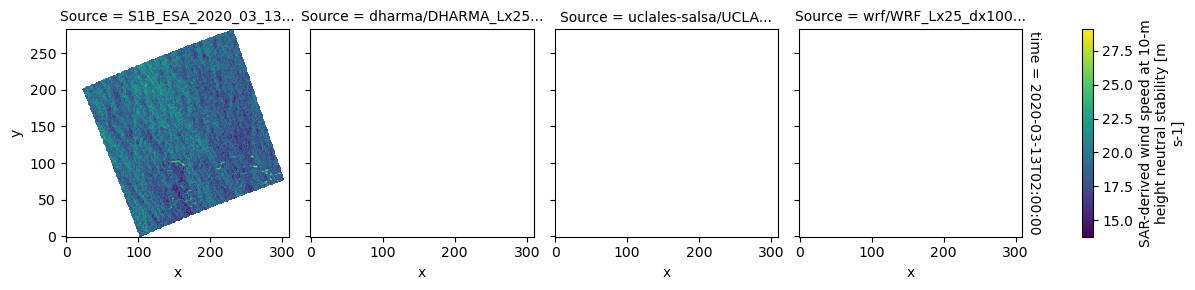

In [124]:
xr.merge([df_col_2d['wspd'],da_stat_ststst.drop('time_diff')])['wind_10m'].plot(row='time',col='Source')

In [10]:
df_col_2d.isel(Source=1)['Source'].data

array('dharma/DHARMA_Lx25_dx100_FixN_2D.nc', dtype='<U49')

In [11]:
import os, sys, tarfile
from pathlib import Path
import netCDF4 as nc
from numpy import *
import matplotlib.pyplot as plt
import glob
import pandas as pd
## test to apply clustering algorithm ###

## certain properties
RES_ORG = 0.1
RES_CLA = 1.0

## certain thresholds
counter = 0
for ss in [2,1]:
    print(ss)
    for tt in [5]:
        pseudo_alb = df_col_2d['alb'].isel(time=tt).isel(Source=ss).data
        opd_cloud  = df_col_2d['opt'].isel(time=tt).isel(Source=ss).data

        THRES_CONNECT = quantile(pseudo_alb[(opd_cloud) > 2.0],0.50)
        THRES_CLOUD   = quantile(pseudo_alb[(opd_cloud) > 2.0],0.50)
    
        if sum(pseudo_alb > THRES_CLOUD) > 1:
            CLUST_COORDS = id_watershed(pseudo_alb,THRES_CLOUD,THRES_CONNECT,plotting=True)
            CLUST_GEOM = cluster_geometry(CLUST_COORDS_BIG,total=[(shape(pseudo_alb)[0]*shape(pseudo_alb)[1])])
            CLUST_GEOM['time']   = df_col_2d.isel(time=tt).isel(Source=ss)['time'].data
            CLUST_GEOM['Source'] = df_col_2d.isel(time=tt).isel(Source=ss)['Source'].data
            print(CLUST_GEOM)
            if counter == 0:
                CLUST_GEOM_COL = pd.concat([CLUST_GEOM])
            else:
                CLUST_GEOM_COL = pd.concat([CLUST_GEOM_COL,CLUST_GEOM])
            counter +=1
    
## coarsen field
#var_coarse = coarsen_2d(pseudo_alb,RES_CLA=RES_CLA,RES_ORG=RES_ORG)
#nx_coa = var_coarse.shape[0]


#plt.imshow(df_col_2d['alb'].isel(time=3).isel(Source=1).data)

2


NameError: name 'id_watershed' is not defined

In [ ]:
CLUST_GEOM_COL

In [ ]:

CLUST_COORDS_BIG = CLUST_COORDS.copy()


CLUST_COORDS_BIG['x'] = (CLUST_COORDS['x']*RES_CLA/RES_ORG) + (RES_CLA/RES_ORG - 1)/2
CLUST_COORDS_BIG['y'] = (CLUST_COORDS['y']*RES_CLA/RES_ORG) + (RES_CLA/RES_ORG - 1)/2

    
CLUST_GEOM = cluster_geometry(CLUST_COORDS_BIG,total=[(shape(pseudo_alb)[0]*shape(pseudo_alb)[1])])
CLUST_GEOM['time'] = 1
pd.concat([CLUST_GEOM,CLUST_GEOM])

In [ ]:
plt.scatter(CLUST_GEOM.index,CLUST_GEOM.area)

In [ ]:

## select simulations to plot
sim_keyword = 'DHARMA_Lx25_dx100_FixN_2D' #UCLALES-SALSA_Lx25_dx100_FixN_2D'  

os.chdir("/user-data-home/comble-mip/notebooks/plotting/")
%run functions_plotting.py 

## load all simulations located in subfolders of the given directory
df_col_2d = load_sims_2d('/data/project/comble-mip/output_les/',var_vec_2d,t_shift=-2,keyword=sim_keyword,times=[t for t in Time_Vec if t > 0],coarsen=True)
var_vec_2d = ['olr11']

df_col_2d['olr11'].plot(row='time',col_wrap=7,col='Source')

In [ ]:
df_col_2d['olr11'].isel(time=0)